# hw_13

为某个网站的用户购买行为信息,构造合适的分类模型，预测用户最终的购买服务类型.
以下数据，第1列为来源网站，第2列为用户所在地区，第3列为是否阅读过FAQ，第4列为浏览网页数，第5列为购买的服务类型（目标变量）,

In [127]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os

my_data=[['slashdot','USA','yes',18,'None'],
         ['google','France','yes',23,'Premium'],
         ['digg','USA','yes',24,'Basic'],
         ['kiwitobes','France','yes',23,'Basic'],
         ['google','UK','no',21,'Premium'],
         ['(direct)','New Zealand','no',12,'None'],
         ['(direct)','UK','no',21,'Basic'],
         ['google','USA','no',24,'Premium'],
         ['slashdot','France','yes',19,'None'],
         ['digg','USA','no',18,'None'],
         ['google','UK','no',18,'None'],
         ['kiwitobes','UK','no',19,'None'],
         ['digg','New Zealand','yes',12,'Basic'],
         ['slashdot','UK','no',21,'None'],
         ['google','UK','yes',18,'Basic'],
         ['kiwitobes','France','yes',19,'Basic']]

In [128]:
data = pd.DataFrame(my_data)
data.columns= ["website","area",
                      "read FAQ?","Page Views","Buying Type"]
data.head()

,website,area,read FAQ?,Page Views,Buying Type
0,slashdot,USA,yes,18,None
1,google,France,yes,23,Premium
2,digg,USA,yes,24,Basic
3,kiwitobes,France,yes,23,Basic
4,google,UK,no,21,Premium


In [129]:

# 数据是类别标签，要将它转换为数据
# website, 按照有无浏览网站分为2类
data.replace('(direct)',-1, inplace=True)
data.replace(['slashdot','google','digg','kiwitobes'],-1, inplace=True)

# area，按照欧洲，美洲进行划分
data.replace(['France','New Zealand','UK'],-1, inplace=True)
data.replace(['USA'],1, inplace=True)


# READ FAQ?
data.replace(['yes'],1, inplace=True)
data.replace(['no'],-1, inplace=True)

# Page Views, 20次作为分水岭
data.loc[data.iloc[:,3] >= 20,'Page Views'] = 1
data.loc[data.iloc[:,3] < 20,'Page Views'] = -1

# Buying Type，按照买或者没买划分
data.loc[data.iloc[:,4] != 'None','Buying Type'] = 1
data.loc[data.iloc[:,4] == 'None','Buying Type'] = -1

x = data.iloc[:,:4].as_matrix().astype(int)
y = data.iloc[:,4].as_matrix().astype(int)
data.head()

,website,area,read FAQ?,Page Views,Buying Type
0,-1,1,1,-1,-1
1,-1,-1,1,-1,1
2,-1,1,1,-1,1
3,-1,-1,1,-1,1
4,-1,-1,-1,-1,1


In [130]:
#拆分训练数据与测试数据 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [137]:
#训练KNN分类器 
knl = KNeighborsClassifier(algorithm='kd_tree')
knl.fit(x_train, y_train)

#测试结果
answer = knl.predict(x_test)
print("x_test: \n",x_test,"\n")
print("answer: \n",answer,"\n")
print("y_test: \n",y_test,"\n")
print("np.mean( answer == y_test): \n",np.mean( answer == y_test),"\n")

#准确率
precision, recall, thresholds = precision_recall_curve(y_train, knl.predict(x_train))
print("classification_report: \n",classification_report(y_test, answer, target_names = ['不买', '买']))

x_test: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1  1  1 -1]
 [-1 -1 -1 -1]] 

answer: 
 [-1 -1 -1 -1] 

y_test: 
 [-1  1  1  1] 

np.mean( answer == y_test): 
 0.25 

classification_report: 
              precision    recall  f1-score   support

         不买       0.25      1.00      0.40         1
          买       0.00      0.00      0.00         3

avg / total       0.06      0.25      0.10         4



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [149]:
####贝叶斯分类器####
#训练贝叶斯分类器
bnb = BernoulliNB() 
bnb.fit(x_train,y_train)


#测试结果
answer = bnb.predict(x_test)
print("x_test: \n",x_test,"\n")
print("answer: \n",answer,"\n")
print("y_test: \n",y_test,"\n")
print("np.mean( answer == y_test): \n",np.mean( answer == y_test),"\n")

print("classification_report: \n",classification_report(y_test, answer, target_names = ['不买', '买']))

x_test: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1  1  1 -1]
 [-1 -1 -1 -1]] 

answer: 
 [-1 -1  1 -1] 

y_test: 
 [-1  1  1  1] 

np.mean( answer == y_test): 
 0.5 

classification_report: 
              precision    recall  f1-score   support

         不买       0.33      1.00      0.50         1
          买       1.00      0.33      0.50         3

avg / total       0.83      0.50      0.50         4



In [147]:
####决策树####
from sklearn.tree import DecisionTreeClassifier as DTC
dtc = DTC(criterion='entropy') #建立决策树模型，基于信息熵
dtc.fit(x_train, y_train) #训练模型

#导入相关函数，可视化决策树。
#导出的结果是一个dot文件，需要安装Graphviz才能将它转换为pdf或png等格式。
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
with open("tree.dot", 'w') as f:
  f = export_graphviz(dtc, out_file = f)


#测试结果
answer = dtc.predict(x_test)

print("x_test: \n",x_test,"\n")
print("answer: \n",answer,"\n")
print("y_test: \n",y_test,"\n")
print("np.mean( answer == y_test): \n",np.mean( answer == y_test),"\n")
print("classification_report: \n",classification_report(y_test, answer, target_names = ['不买', '买']))

x_test: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1  1  1 -1]
 [-1 -1 -1 -1]] 

answer: 
 [-1 -1 -1 -1] 

y_test: 
 [-1  1  1  1] 

np.mean( answer == y_test): 
 0.25 

classification_report: 
              precision    recall  f1-score   support

         不买       0.25      1.00      0.40         1
          买       0.00      0.00      0.00         3

avg / total       0.06      0.25      0.10         4



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


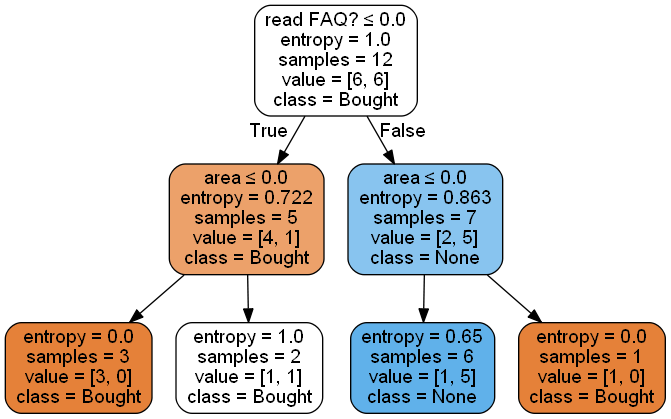

In [144]:
import sklearn.tree as tree
import pydotplus 
from IPython.display import Image

#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#dtc = DTC(criterion='entropy') #建立决策树模型，基于信息熵
#dtc_fit = dtc.fit(x_train, y_train) 

clf= DTC(criterion='entropy')
clf_fit=clf.fit(x_train, y_train) 

dot_data = tree.export_graphviz(clf_fit, 
                                out_file=None,
                                feature_names=["website","area","read FAQ?","Page Views"], 
                                class_names=["Bought","None"], 
                                filled=True, rounded=True, 
                                special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [146]:
####SVM####
from sklearn.svm import SVC
svc =SVC() #线性可分时，使用SVC
svc.fit(x_train, y_train)  

#测试结果
answer = svc.predict(x_test)

print("x_test: \n",x_test,"\n")
print("answer: \n",answer,"\n")
print("y_test: \n",y_test,"\n")
print("np.mean( answer == y_test): \n",np.mean( answer == y_test),"\n")

print("classification_report: \n",classification_report(y_test, answer, target_names = ['不买', '买']))

x_test: 
 [[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1  1  1 -1]
 [-1 -1 -1 -1]] 

answer: 
 [-1 -1 -1 -1] 

y_test: 
 [-1  1  1  1] 

np.mean( answer == y_test): 
 0.25 

classification_report: 
              precision    recall  f1-score   support

         不买       0.25      1.00      0.40         1
          买       0.00      0.00      0.00         3

avg / total       0.06      0.25      0.10         4



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
